In [1]:
from keras.layers import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.merge import Add
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.utils import plot_model

#%%
class ResNet():
    
    def __init__(self,
                 filters_list=[],
                 input_size=None,
                 output_size=None,
                 initializer='glorot_uniform'):
        self.filters_list = filters_list
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None

    def _block(self, filters, inp):
        
        layer_1 = BatchNormalization()(inp)
        act_1 = Activation('relu')(layer_1)
        conv_1 = Conv2D(filters, (3,3),
                        padding = 'same',
                        kernel_initializer = self.initializer)(act_1)
        layer_2 = BatchNormalization()(conv_1)
        act_2 = Activation('relu')(layer_2)
        conv_2 = Conv2D(filters, (3,3),
                        padding = 'same',
                        kernel_initializer = self.initializer)(act_2)
        return(conv_2)

    def build(self):
        
        i = Input(shape = self.input_size, name = 'input')
        x = Conv2D(self.filters_list[0], (3,3),
                   padding = 'same',
                   kernel_initializer = self.initializer)(i)
        x = MaxPooling2D(padding = 'same')(x)
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        if len(self.filters_list) > 1:
            for filt in self.filters_list[1:]:
                x = Conv2D(filt, (3,3),
                           strides = (2,2),
                           padding = 'same',
                           activation = 'relu',
                           kernel_initializer = self.initializer)(x)
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
        x = GlobalAveragePooling2D()(x)
        x = Dense(self.output_size, activation = 'softmax')(x)

        self.m = Model(i,x)
        return self.m

Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from time import time
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
X_train = np.load('./data/X_train.npy')
Y_train = np.load('./data/Y_train.npy')
X_val = np.load('./data/X_val.npy')
Y_val = np.load('./data/Y_val.npy')

In [6]:
X_train.shape

(63769, 122, 85, 1)

In [7]:
Y_train.shape

(63769,)

In [8]:
X_val.shape

(42462, 122, 85, 1)

In [9]:
Y_val.shape

(42462,)

In [10]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'backward', 'forward',
           'house',
           'silence', 'unknown']

all_classes = [x for x in classes[:14]]
for ind, cl in enumerate(os.listdir('data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'backward', 'forward', 'house', 'silence', 'eight', 'cat', 'tree', 'learn', 'bed', 'happy', 'dog', 'wow', 'follow', 'nine', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'visual', 'marvin', 'two', 'six', 'five', 'four']


In [11]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights = get_class_weights(Y_train) 

In [12]:
class_weights

{5: 16.396825396825395,
 14: 1.0,
 10: 37.22522522522522,
 9: 15.967367969085444,
 13: 153.6694214876033,
 1: 15.72431289640592,
 4: 16.30337571240684,
 8: 16.001721170395868,
 2: 16.638926174496643,
 12: 29.30496453900709,
 3: 15.817949808592088,
 0: 15.322620519159456,
 6: 16.11265164644714,
 11: 39.77326203208556,
 7: 16.54270462633452}

In [13]:
input_size = X_train.shape[1:]
batch_size = 196

In [14]:
filters_list = [8,16,32]
output_size = 15

In [15]:
#adjust these strings for organizeing the saved files
date = '1003'
arch = 'resnet8_16_32'

In [16]:
sr = ResNet(filters_list, input_size, output_size)
sr.build()
sr.m.compile(loss='categorical_crossentropy', 
             optimizer='adadelta', 
             metrics=['accuracy'])

In [17]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr.m, 
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [18]:
#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)

In [19]:
from keras.utils import to_categorical

In [20]:
history = sr.m.fit(X_train, 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   epochs = 5, 
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights,
                   validation_data = (X_val, to_categorical(Y_val)), 
                   callbacks = [checkpointer]) # add more callbacks if you want

Train on 63769 samples, validate on 42462 samples
Epoch 1/5
63769/63769 [==============================] - 1298s 20ms/step - loss: 11.1313 - acc: 0.3967 - val_loss: 2.4426 - val_acc: 0.4045
Epoch 2/5
63769/63769 [==============================] - 1261s 20ms/step - loss: 4.0153 - acc: 0.6984 - val_loss: 1.0617 - val_acc: 0.6484
Epoch 3/5
63769/63769 [==============================] - 1240s 19ms/step - loss: 2.9159 - acc: 0.7756 - val_loss: 1.8725 - val_acc: 0.5023
Epoch 4/5
63769/63769 [==============================] - 1227s 19ms/step - loss: 2.4234 - acc: 0.8123 - val_loss: 0.7007 - val_acc: 0.7656
Epoch 5/5
63769/63769 [==============================] - 1226s 19ms/step - loss: 2.0129 - acc: 0.8423 - val_loss: 0.4797 - val_acc: 0.8570


In [21]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date))

In [22]:
from keras.models import load_model

sr.m.save('./models/ResNet.h5')  # creates a HDF5 file 'my_model.h5'

# returns a compiled model
# identical to the previous one
modelResNet = load_model('./models/ResNet.h5')

In [23]:
X_val[0].shape

(122, 85, 1)

plot the training graphs, and save them

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


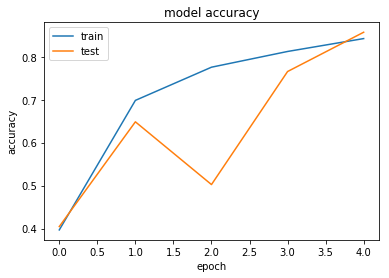

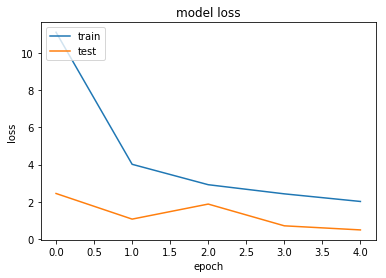

In [26]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

predict the validation classification and score

In [27]:
val_pred = sr.m.predict(X_val, batch_size = batch_size, verbose = 1)

42462/42462 [==============================] - 301s 7ms/step


In [28]:
val_pred.shape

(42462, 15)

In [29]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

             precision    recall  f1-score   support

        yes      0.798     0.962     0.873      1617
         no      0.828     0.861     0.844      1576
         up      0.986     0.515     0.676      1488
       down      0.954     0.560     0.706      1566
       left      0.858     0.861     0.859      1520
      right      0.903     0.856     0.879      1510
         on      0.906     0.774     0.835      1537
        off      0.952     0.664     0.782      1497
       stop      0.989     0.467     0.634      1548
         go      0.725     0.765     0.745      1551
   backward      0.843     0.526     0.648       665
    forward      0.546     0.756     0.634       622
      house      0.979     0.732     0.838       844
    silence      0.668     0.981     0.795       160
    unknown      0.861     0.951     0.904     24761

avg / total      0.868     0.857     0.850     42462



In [30]:
print(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1)))

[[ 1556     0     0     0    11     0     0     0     0     0     0     0
      0     4    46]
 [   14  1357     0     1    14     2     0     1     0    12     0     1
      0     1   173]
 [    0     4   766     0     0     2    45    29     7    23    52    10
      2     6   542]
 [   14    82     0   877     4     0     1     1     0    53     1     2
      0     1   530]
 [   15     2     0     0  1309    45     0     0     0     1     1     1
      0     0   146]
 [    2     2     0     0    13  1292     1     0     0     0     0     2
      0     1   197]
 [    0     0     3     2     1     0  1190     8     0     7     1    27
      2     5   291]
 [   49     3     2     0    11     1    56   994     0     5     1    14
      2     2   357]
 [    2     0     1     5     2     0     0     0   723    41     2     2
      0     1   769]
 [   13    91     0     1     3     0     0     0     0  1187     0    10
      0     4   242]
 [    1     0     1     1     8     5     0     0 